In [3]:
import pandas as pd
import networkx as nx
import powerlaw

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('271014744_T_ONTIME_REPORTING.csv')

In [21]:
df.head()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 16
0,2019-01-01,9E,MSP,MKE,1122,1155.0,1251,1259.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,9E,ATL,PHF,954,1002.0,1137,1132.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,9E,PHF,ATL,1213,1207.0,1410,1408.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,9E,MSP,CLE,1005,1015.0,1302,1257.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,9E,MSP,RDU,1540,1535.0,1921,1854.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df.rename(columns={
    'CRS_DEP_TIME': 'Schedule_departure_TIME', 
    'DEP_TIME': 'Actual_depature_TIME', 
    'CRS_ARR_TIME': 'schedule_arrival_TIME', 
    'ARR_TIME': 'Actual_arrival_TIME'
}, inplace=True)



In [7]:
df['ORIGIN'].value_counts().head()

ATL    31151
ORD    26212
DFW    23078
CLT    19105
DEN    18498
Name: DEST, dtype: int64

In [8]:
df['DEST'].value_counts().head(10)

ATL    31151
ORD    26212
DFW    23078
CLT    19105
DEN    18498
Name: DEST, dtype: int64

The Atlanta International Airport (ATL) appears to be the busiest airport in terms of originating flights, with a total of 31,151 departures. This high number of departures signifies that ATL is a significant hub in the air travel network.

Chicago's O'Hare International Airport (ORD) follows closely behind, accounting for 26,212 originating flights, thus making it the second busiest hub in terms of departures.

The Dallas/Fort Worth International Airport (DFW) is the third busiest, with 23,078 originating flights.

Charlotte Douglas International Airport (CLT) and Denver International Airport (DEN) are the fourth and fifth busiest airports, with 19,105 and 18,498 originating flights, respectively.

#### From the destination perspective, if we consider the frequency of 'Flight_DESTINATION', we got a similar list, indicating the most frequented airports for arrivals. The higher the number of arrivals and departures, the more significant an airport is as a hub

### Most Commonly used Flight Legs

In [12]:
flight_leg_counts = df.groupby(['ORIGIN','DEST']).size().reset_index(name='counts')
flight_leg_counts = flight_leg_counts.sort_values(by='counts', ascending=False)

In [16]:
print(flight_leg_counts)

     ORIGIN DEST  counts
2841    LAX  SFO    1285
4930    SFO  LAX    1283
3842    ORD  LGA    1230
2940    LGA  ORD    1230
2805    LAX  JFK    1064
...     ...  ...     ...
2857    LBB  HOU       1
2194    HOU  PHL       1
4683    SAT  SFB       1
3603    MTJ  LGA       1
2420    IAH  STT       1

[5535 rows x 3 columns]


C:\Users\Sadeeq\AppData\Local\Temp\ipykernel_32256\4016283069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top30_flight_legs['flight_leg'] = top30_flight_legs['ORIGIN'] + ' to ' + top30_flight_legs['DEST']


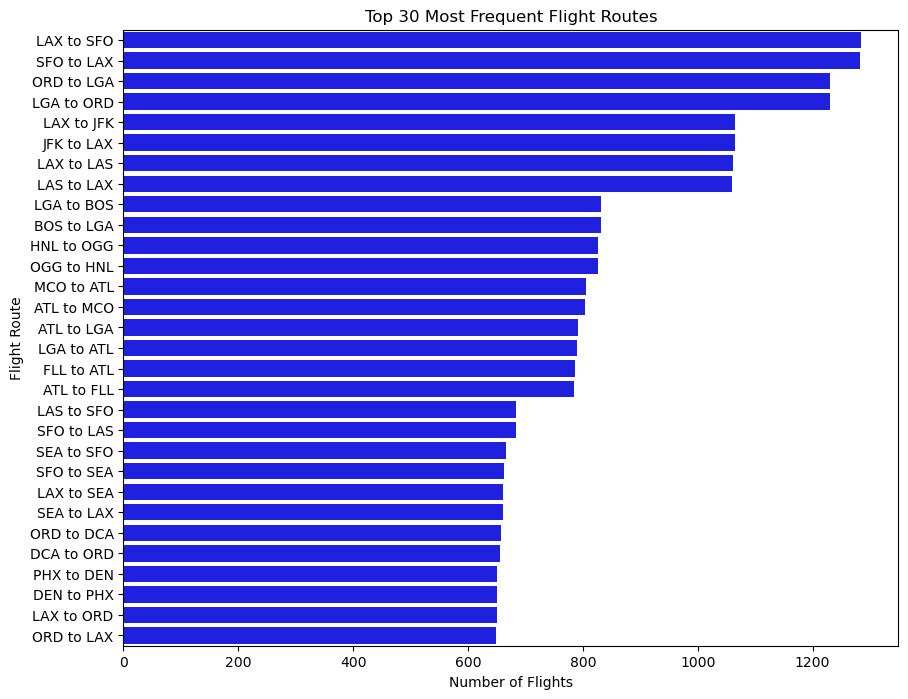

In [65]:
# Select the top 30 flight routes
top30_flight_legs = flight_leg_counts.head(30)

# Create a new column for better labeling on the x-axis
top30_flight_legs['flight_leg'] = top30_flight_legs['ORIGIN'] + ' to ' + top30_flight_legs['DEST']

# Plot
plt.figure(figsize=[10,8])
sns.barplot(y='flight_leg', x='counts', data=top30_flight_legs, orient='h', color='blue')
plt.xlabel('Number of Flights')
plt.ylabel('Flight Route')
plt.title('Top 30 Most Frequent Flight Routes')
plt.show()

In [17]:
flight_leg_counts.to_csv('flight_leg_counts.csv', index=False)

In [18]:
flight_leg = pd.read_csv('flight_leg_counts.csv')

In [20]:
flight_leg.head(10)

,ORIGIN,DEST,counts
0,LAX,SFO,1285
1,SFO,LAX,1283
2,ORD,LGA,1230
3,LGA,ORD,1230
4,LAX,JFK,1064
5,JFK,LAX,1064
6,LAX,LAS,1061
7,LAS,LAX,1059
8,LGA,BOS,832
9,BOS,LGA,832


#### What are the Peak times and days for flights

### Peak Days

In [23]:
# Convert 'Flight_date' to datetime 
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Extract day of week from 'Flight_date'
df['day_of_week'] = df['FL_DATE'].dt.day_name()

# Count flights for each day of the week
flight_days = df['day_of_week'].value_counts()

# Display days with the most flights
print(flight_days)


Thursday     99387
Wednesday    96920
Tuesday      92796
Friday       79698
Monday       79401
Sunday       73459
Saturday     62324
Name: day_of_week, dtype: int64


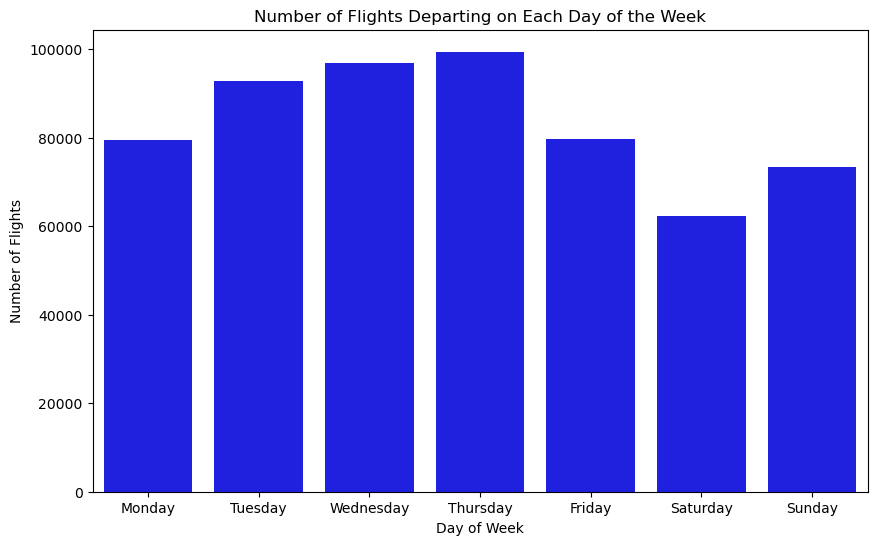

In [64]:
# Convert flight_days from Series to DataFrame and reset index
flight_days_df = flight_days.reset_index()
flight_days_df.columns = ['Day', 'Count']

# Sort DataFrame by day of week
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
flight_days_df['Day'] = pd.Categorical(flight_days_df['Day'], categories=cats, ordered=True)
flight_days_df = flight_days_df.sort_values('Day')

# Plot
plt.figure(figsize=[10,6])
sns.barplot(x='Day', y='Count', data=flight_days_df, color='blue')
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')
plt.title('Number of Flights Departing on Each Day of the Week')
plt.show()


In [26]:
df.head()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,Schedule_departure_TIME,Actual_depature_TIME,schedule_arrival_TIME,Actual_arrival_TIME,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 16,day_of_week
0,2019-01-01,9E,MSP,MKE,1122,1155.0,1251,1259.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
1,2019-01-01,9E,ATL,PHF,954,1002.0,1137,1132.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
2,2019-01-01,9E,PHF,ATL,1213,1207.0,1410,1408.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
3,2019-01-01,9E,MSP,CLE,1005,1015.0,1302,1257.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
4,2019-01-01,9E,MSP,RDU,1540,1535.0,1921,1854.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday


### Peak Times

In [27]:
# Convert 'DEP_TIME' to string
df['Schedule_departure_TIME'] = df['Schedule_departure_TIME'].astype(str)

# If 'DEP_TIME' has less than 4 digits (because leading zeros are lost when read as integer), add leading zeros
df['Schedule_departure_TIME'] = df['Schedule_departure_TIME'].str.zfill(4)

# Convert 'DEP_TIME' to datetime format
df['Schedule_departure_TIME'] = pd.to_datetime(df['Schedule_departure_TIME'], format='%H%M')

# Extract hour from 'DEP_TIME'
df['departure_hour'] = df['Schedule_departure_TIME'].dt.hour

# Count flights for each hour of the day
flight_hours = df['departure_hour'].value_counts()

# Display hours with the most flights
print(flight_hours)


6     41971
8     39031
7     38450
17    37254
12    36918
11    36774
15    35988
14    35925
10    35768
16    35250
18    34670
9     34384
13    33413
19    31823
20    26057
21    17844
5     13653
22    13019
23     3569
0      1147
1       520
3       247
4       163
2       147
Name: departure_hour, dtype: int64


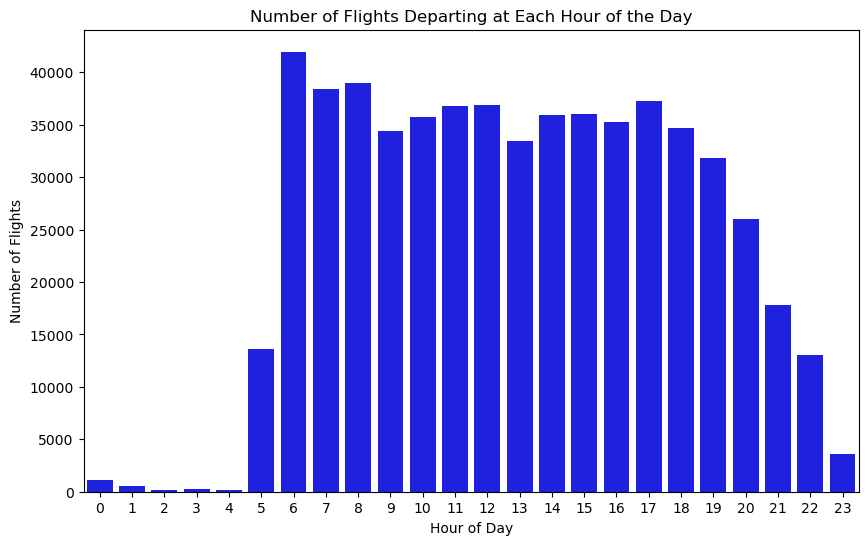

In [63]:
# Convert flight_hours from Series to DataFrame and reset index
flight_hours_df = flight_hours.reset_index()
flight_hours_df.columns = ['Hour', 'Count']

# Sort DataFrame by hour
flight_hours_df = flight_hours_df.sort_values('Hour')

# Plot
plt.figure(figsize=[10,6])
sns.barplot(x='Hour', y='Count', data=flight_hours_df, color='blue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.title('Number of Flights Departing at Each Hour of the Day')
plt.xticks(range(0, 24))
plt.show()


In [36]:
# Convert the 'Actual_arrival_TIME' and 'schedule_arrival_TIME' to datetime format
df['Actual_arrival_TIME'] = pd.to_datetime(df['Actual_arrival_TIME'], errors='coerce')
df['schedule_arrival_TIME'] = pd.to_datetime(df['schedule_arrival_TIME'], errors='coerce')

# Calculate the delay in minutes
df['delay_minutes'] = (df['Actual_arrival_TIME'] - df['schedule_arrival_TIME']).dt.total_seconds() / 60


In [37]:
# Calculate average delay
average_delay = df['delay_minutes'].mean()
print('Average delay:', average_delay, 'minutes')


Average delay: -15.752507088520668 minutes


In [46]:
# Identify flight legs with most often delayed
delayed_flights = df[df['delay_minutes'] > 0]
most_delayed_flights = delayed_flights.groupby(['ORIGIN', 'DEST']).size().sort_values(ascending=False)
print('Most often delayed flights:\n', most_delayed_flights)

Most often delayed flights:
 ORIGIN  DEST
ORD     LGA     610
LGA     ORD     549
SFO     LAX     494
LAX     SFO     461
LAS     LAX     423
               ... 
BOS     SMF       1
HNL     SLC       1
MIA     BUF       1
SEA     BZN       1
HDN     FLL       1
Length: 5405, dtype: int64


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt


C:\Users\Sadeeq\AppData\Local\Temp\ipykernel_32256\3074210380.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_delayed_flights['flight_leg'] = top10_delayed_flights['ORIGIN'] + ' to ' + top10_delayed_flights['DEST']


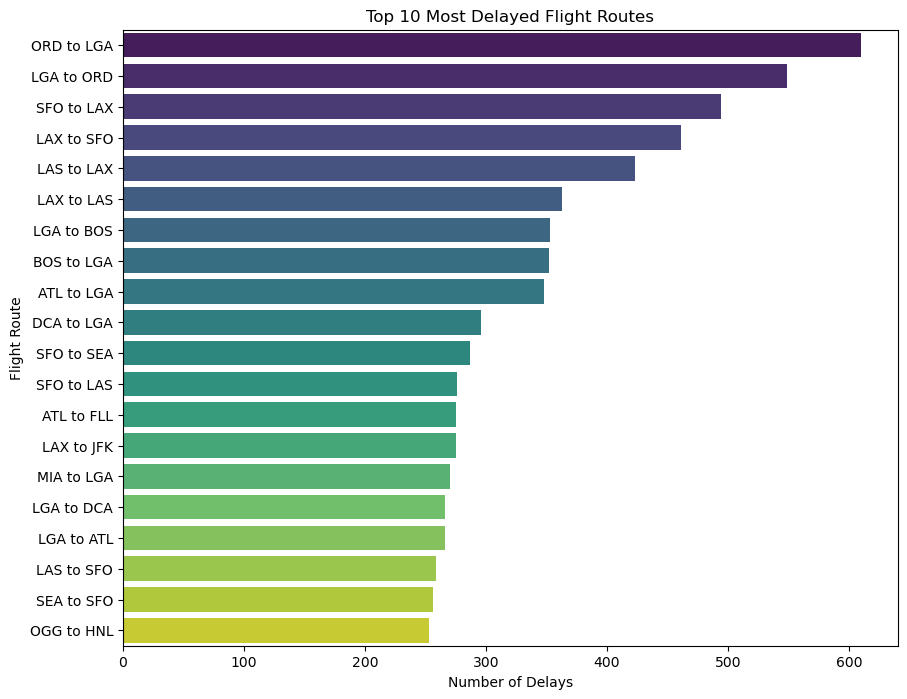

In [66]:
# Identify flight legs with most often delayed
delayed_flights = df[df['delay_minutes'] > 0]
most_delayed_flights = delayed_flights.groupby(['ORIGIN', 'DEST']).size().reset_index(name='delay_count')
most_delayed_flights = most_delayed_flights.sort_values('delay_count', ascending=False)

# Select top 10
top10_delayed_flights = most_delayed_flights.head(20)

# Create a new column combining 'ORIGIN' and 'DEST' to serve as the label for the x-axis
top10_delayed_flights['flight_leg'] = top10_delayed_flights['ORIGIN'] + ' to ' + top10_delayed_flights['DEST']

# Plot
plt.figure(figsize=[10,8])
sns.barplot(x='delay_count', y='flight_leg', data=top10_delayed_flights, palette='viridis', orient='h')
plt.xlabel('Number of Delays')
plt.ylabel('Flight Route')
plt.title('Top 10 Most Delayed Flight Routes')
plt.show()


In [47]:
# Identify flight legs with most often delayed
delayed_flights = df[df['delay_minutes'] > 0]
most_delayed_flights = delayed_flights.groupby(['ORIGIN', 'DEST']).size().reset_index(name='delay_count')
most_delayed_flightss = most_delayed_flights.sort_values('delay_count', ascending=False)
print('Most often delayed flights:\n', most_delayed_flightss)


Most often delayed flights:
      ORIGIN DEST  delay_count
3763    ORD  LGA          610
2882    LGA  ORD          549
4816    SFO  LAX          494
2786    LAX  SFO          461
2652    LAS  LAX          423
...     ...  ...          ...
583     BOS  SMF            1
2113    HNL  SLC            1
3223    MIA  BUF            1
4661    SEA  BZN            1
2073    HDN  FLL            1

[5405 rows x 3 columns]


In [48]:
most_delayed_flightss.to_csv('most_delayed_flights.csv', index=False)

In [50]:
most_delayedd = pd.read_csv('most_delayed_flights.csv')

In [51]:
most_delayedd.head()

,ORIGIN,DEST,delay_count
0,ORD,LGA,610
1,LGA,ORD,549
2,SFO,LAX,494
3,LAX,SFO,461
4,LAS,LAX,423


### Airlines with Longest Delays

In [42]:
# Group delays by airline
delays_by_airline = delayed_flights.groupby('OP_CARRIER')['delay_minutes'].mean().sort_values(ascending=False)
print('Airlines with longest delays:\n', delays_by_airline)

Airlines with longest delays:
 OP_CARRIER
B6    59.435825
OO    53.070418
EV    47.596154
9E    46.949700
UA    44.033469
YX    42.711279
F9    41.750577
DL    39.434141
NK    39.321352
AS    37.084054
MQ    36.674836
G4    33.634894
YV    33.330078
AA    32.577418
OH    30.209061
WN    28.137881
HA    16.692308
Name: delay_minutes, dtype: float64


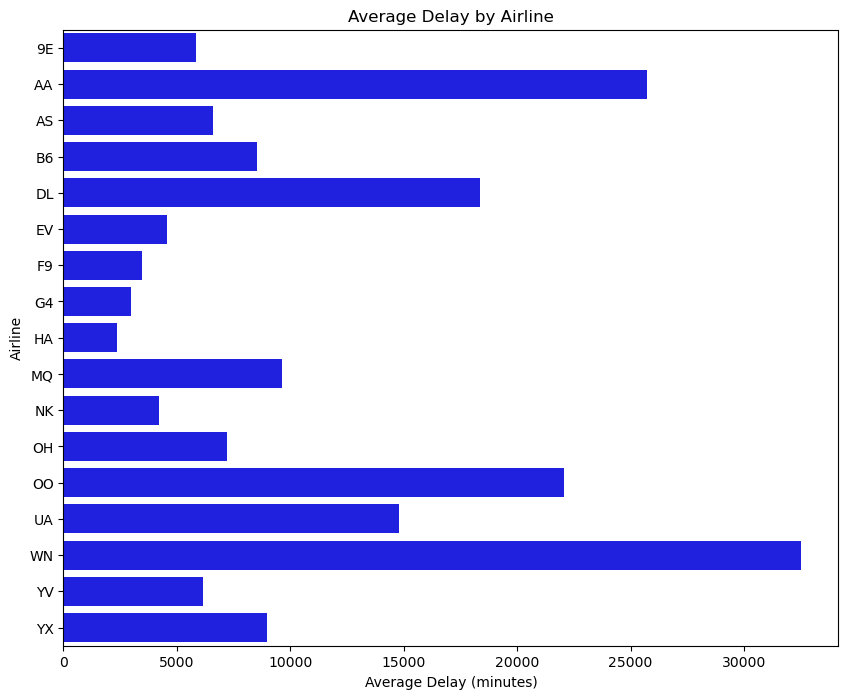

In [67]:
# Convert delays_by_airline from Series to DataFrame and reset index
delays_by_airline_df = delays_by_airline.reset_index()
delays_by_airline_df.columns = ['Airline', 'Avg_Delay']

# Plot
plt.figure(figsize=[10,8])
sns.barplot(y='Airline', x='Avg_Delay', data=delays_by_airline_df, orient='h', color='blue')
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Airline')
plt.title('Average Delay by Airline')
plt.show()


In [56]:
# Calculate number of cancellations by airline
cancellations_by_airline = df.groupby('OP_CARRIER')['CANCELLED'].sum()
print("Cancellations by airline:\n", cancellations_by_airline)

Cancellations by airline:
 OP_CARRIER
9E     341.0
AA    1511.0
AS     429.0
B6     980.0
DL     328.0
EV     964.0
F9     151.0
G4      50.0
HA       7.0
MQ    1939.0
NK     199.0
OH     751.0
OO    2821.0
UA     697.0
WN    3949.0
YV     477.0
YX    1132.0
Name: CANCELLED, dtype: float64


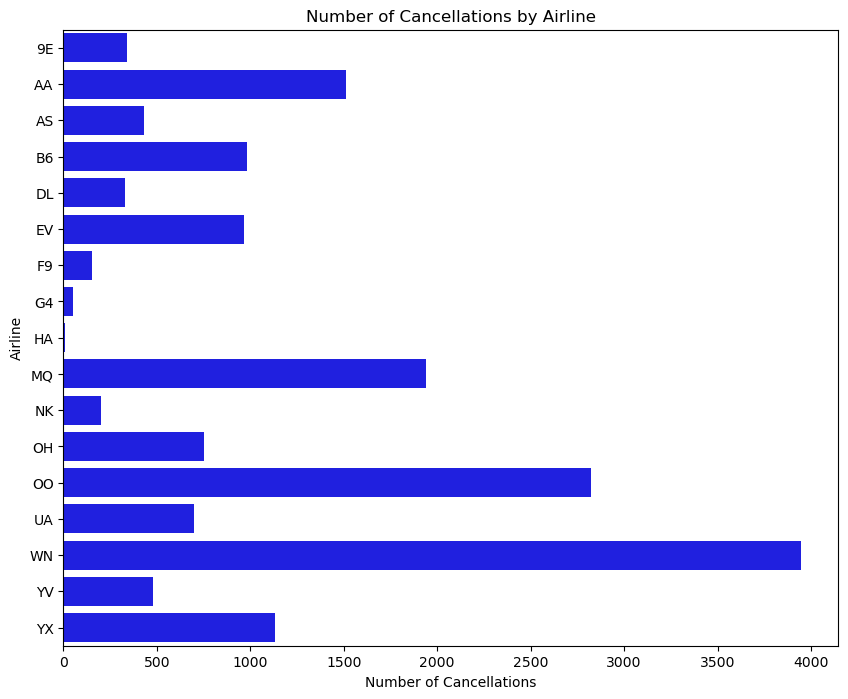

In [68]:
# Convert cancellations_by_airline from Series to DataFrame and reset index
cancellations_by_airline_df = cancellations_by_airline.reset_index()
cancellations_by_airline_df.columns = ['Airline', 'Number_of_Cancellations']

# Plot
plt.figure(figsize=[10,8])
sns.barplot(y='Airline', x='Number_of_Cancellations', data=cancellations_by_airline_df, orient='h', color='blue')
plt.xlabel('Number of Cancellations')
plt.ylabel('Airline')
plt.title('Number of Cancellations by Airline')
plt.show()


In [57]:
# Calculate number of delays by airline
delays_by_airline = df[df['delay_minutes'] > 0].groupby('OP_CARRIER')['delay_minutes'].count()
print("Delays by airline:\n", delays_by_airline)

Delays by airline:
 OP_CARRIER
9E     5825
AA    25711
AS     6591
B6     8547
DL    18365
EV     4576
F9     3464
G4     2969
HA     2379
MQ     9629
NK     4201
OH     7218
OO    22054
UA    14790
WN    32528
YV     6144
YX     8981
Name: delay_minutes, dtype: int64


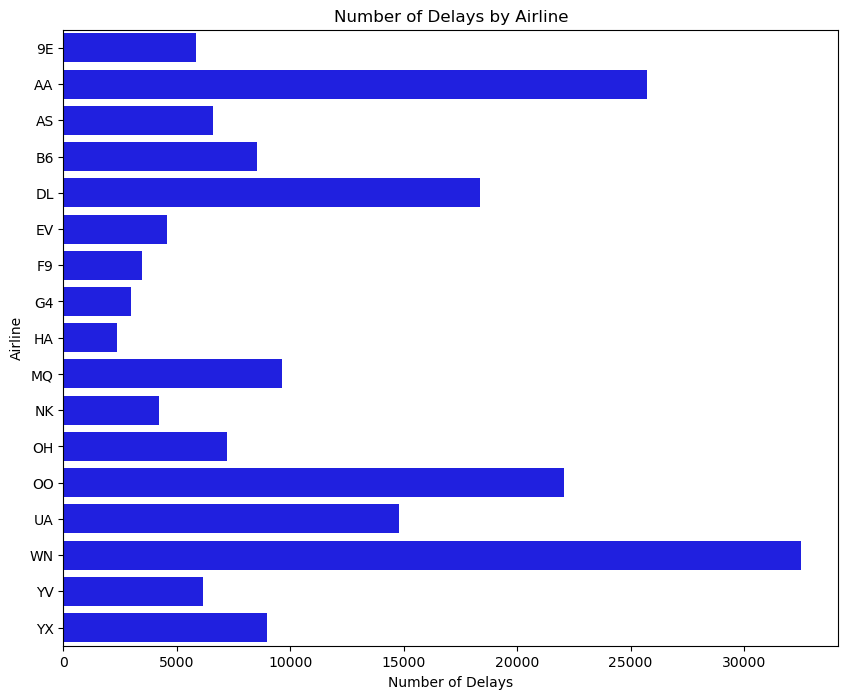

In [69]:
# Convert delays_by_airline from Series to DataFrame and reset index
delays_by_airline_df = delays_by_airline.reset_index()
delays_by_airline_df.columns = ['Airline', 'Number_of_Delays']

# Plot
plt.figure(figsize=[10,8])
sns.barplot(y='Airline', x='Number_of_Delays', data=delays_by_airline_df, orient='h', color='blue')
plt.xlabel('Number of Delays')
plt.ylabel('Airline')
plt.title('Number of Delays by Airline')
plt.show()
